In [61]:
import h5py
import torch
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt

In [2]:
CONFIG = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

def load_torch_weights(file_path):
    """Load model weights from a checkpoint file."""
    try:
        weights = torch.load(file_path, map_location='cpu')
        return weights['model']
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
        
def extract_hash_encoding_structure(model_weights, num_levels=16, level_dim=2, input_dim=3, log2_hashmap_size=19, base_resolution=16):
    """
    Extract and organize hash encoding weights into hierarchical structure.
    
    Args:
        model_weights (dict): The loaded model weights dictionary
        num_levels (int): Number of levels in hash encoding
        level_dim (int): Dimension of encoding at each level
        input_dim (int): Input dimension (typically 3 for 3D)
        log2_hashmap_size (int): Log2 of maximum hash table size
        base_resolution (int): Base resolution of the grid
        
    Returns:
        dict: Hierarchical structure of hash encoding weights
    """
    # Extract hash encoding embeddings
    embeddings = model_weights['_orig_mod.grid_encoder.embeddings']
    
    # Calculate per-level parameters
    max_params = 2 ** log2_hashmap_size
    per_level_scale = np.exp2(np.log2(2048 / base_resolution) / (num_levels - 1))
    
    # Initialize structure to store weights
    hash_structure = {}
    offset = 0
    
    for level in range(num_levels):
        # Calculate resolution at this level
        resolution = int(np.ceil(base_resolution * (per_level_scale ** level)))
        
        # Calculate number of parameters for this level
        params_in_level = min(max_params, (resolution) ** input_dim)
        params_in_level = int(np.ceil(params_in_level / 8) * 8)  # make divisible by 8
        
        # Extract weights for this level
        level_weights = embeddings[offset:offset + params_in_level]
        
        # Store level information
        hash_structure[f'level_{level}'] = {
            'resolution': resolution,
            'num_params': params_in_level,
            'weights': level_weights,
            'weights_shape': level_weights.shape,
            'scale': per_level_scale ** level
        }
        
        offset += params_in_level
    
    # Add global information
    hash_structure['global_info'] = {
        'total_params': offset,
        'embedding_dim': level_dim,
        'base_resolution': base_resolution,
        'max_resolution': int(np.ceil(base_resolution * (per_level_scale ** (num_levels-1)))),
        'per_level_scale': per_level_scale
    }
    
    return hash_structure

def extract_mlp_weights(model_weights):
    """Extract geometric and view-dependent MLP weights from the model."""
    geometry_layers = {}
    view_mlp_layers = {}
    
    # Extract geometry MLP weights
    for i in range(CONFIG['mlp']['num_layers']):
        weight_key = f'_orig_mod.grid_mlp.net.{i}.weight'
        bias_key = f'_orig_mod.grid_mlp.net.{i}.bias'
        
        if weight_key in model_weights:
            geometry_layers[f'layer_{i}'] = {
                'weights': model_weights[weight_key],
                'shape': model_weights[weight_key].shape
            }
            
            if bias_key in model_weights:
                geometry_layers[f'layer_{i}']['bias'] = model_weights[bias_key]
    
    # Extract view-dependent MLP weights
    for i in range(CONFIG['mlp']['num_layers']):
        weight_key = f'_orig_mod.view_mlp.net.{i}.weight'
        bias_key = f'_orig_mod.view_mlp.net.{i}.bias'
        
        if weight_key in model_weights:
            view_mlp_layers[f'layer_{i}'] = {
                'weights': model_weights[weight_key],
                'shape': model_weights[weight_key].shape
            }
            
            if bias_key in model_weights:
                view_mlp_layers[f'layer_{i}']['bias'] = model_weights[bias_key]
    
    return {
        'geometry_mlp': geometry_layers,
        'view_mlp': view_mlp_layers
    }

# Example usage


In [3]:
data_path = "../../ten_objs/ten_objs/shared_data/CarrotKhanStatue/base_000_000_000/checkpoints"
nerf = load_torch_weights(data_path + "/final.pth")
mlp_weights = extract_mlp_weights(nerf)
mrhe_by_layer = extract_hash_encoding_structure(nerf)

del mrhe_by_layer["global_info"]


for key,value in mlp_weights["geometry_mlp"].items():
    new_key = "geo_" + key
    mrhe_by_layer[new_key] = value

for key,value in mlp_weights["view_mlp"].items():
    new_key = "view_" + key
    mrhe_by_layer[new_key] = value

with h5py.File(data_path + "/final.h5", "w") as h5f:
    for name, tensor in mrhe_by_layer.items():
        h5f.create_dataset(name, data=tensor["weights"].numpy(), compression="gzip")

In [9]:
objects = glob.glob("../../../../../../..//media/boz/408422C88422C070/ada_and_hal/*")
files = []
for obj in objects:
    files += glob.glob(obj +  "/*/checkpoints/*.pth")

files.sort()

for ix,data_path in enumerate(files):
    data_path = data_path.replace("/final.pth", "")
    nerf = load_torch_weights(data_path + "/final.pth")
    mlp_weights = extract_mlp_weights(nerf)
    mrhe_by_layer = extract_hash_encoding_structure(nerf)
    
    del mrhe_by_layer["global_info"]
    
    
    for key,value in mlp_weights["geometry_mlp"].items():
        new_key = "geo_" + key
        mrhe_by_layer[new_key] = value
    
    for key,value in mlp_weights["view_mlp"].items():
        new_key = "view_" + key
        mrhe_by_layer[new_key] = value

    print(data_path + "/final.h5")
    with h5py.File(data_path + "/final.h5", "w") as h5f:
        for name, tensor in mrhe_by_layer.items():
            h5f.create_dataset(name, data=tensor["weights"].numpy(), compression="gzip")
    print(data_path)


../../../../../../..//media/boz/408422C88422C070/ada_and_hal/1Story/base_000_000_000/checkpoints/final.h5
../../../../../../..//media/boz/408422C88422C070/ada_and_hal/1Story/base_000_000_000/checkpoints
../../../../../../..//media/boz/408422C88422C070/ada_and_hal/1Story/compound_090_000_090/checkpoints/final.h5
../../../../../../..//media/boz/408422C88422C070/ada_and_hal/1Story/compound_090_000_090/checkpoints
../../../../../../..//media/boz/408422C88422C070/ada_and_hal/1Story/x_180_000_000/checkpoints/final.h5


KeyboardInterrupt: 

In [33]:
objects = glob.glob("../../data/*")
files = []
for obj in objects:
    files += glob.glob(obj +  "/*/checkpoints/*.h5")

files.sort()

In [49]:
problem_files = []
def visit(name, obj):
    global problem_files
    flag = torch.isnan(torch.from_numpy(obj[:])).any()
    if flag:
        problem_files.append(file)
    

for ix, file in enumerate(files):
    with h5py.File(file, "r") as h5f:
        h5f.visititems(visit)
    print(f"{100 * ix / len(files) : .2f}%", end = "\r")

In [51]:
set(problem_files)

{'../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/AsteroidOne/compound_090_000_090/checkpoints/final.h5',
 '../../data/Astronaut@Great Sword Walk/z_000_000_120/checkpoints/final.h5',
 '../../data/Docile/z_000_000_120/checkpoints/final.h5',
 '../../data/Furniture_Table_2/compound_090_000_090/checkpoints/final.h5',
 '../../data/Granade 1/z_000_000_120/checkpoints/final.h5',
 '../../data/dollar/x_180_000_000/checkpoints/final.h5'}

In [52]:
problem_files

['../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_090_000_090/checkpoints/final.h5',
 '../../data/ATV-Truck-1/compound_

In [59]:
glob.glob("../../data/*/*/checkpoints/*.h5")

['../../data/block_purple/z_000_000_240/checkpoints/final.h5',
 '../../data/block_purple/y_000_180_000/checkpoints/final.h5',
 '../../data/block_purple/compound_090_000_090/checkpoints/final.h5',
 '../../data/block_purple/x_180_000_000/checkpoints/final.h5',
 '../../data/block_purple/base_000_000_000/checkpoints/final.h5',
 '../../data/block_purple/z_000_000_120/checkpoints/final.h5',
 '../../data/kork_chanShape/z_000_000_240/checkpoints/final.h5',
 '../../data/kork_chanShape/y_000_180_000/checkpoints/final.h5',
 '../../data/kork_chanShape/compound_090_000_090/checkpoints/final.h5',
 '../../data/kork_chanShape/x_180_000_000/checkpoints/final.h5',
 '../../data/kork_chanShape/base_000_000_000/checkpoints/final.h5',
 '../../data/kork_chanShape/z_000_000_120/checkpoints/final.h5',
 '../../data/Mesh_Fence_Stone/z_000_000_240/checkpoints/final.h5',
 '../../data/Mesh_Fence_Stone/y_000_180_000/checkpoints/final.h5',
 '../../data/Mesh_Fence_Stone/compound_090_000_090/checkpoints/final.h5',
 '..

In [177]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import tiktoken
from datasets import load_dataset


from deeppy import Network, IngpData, LearnFrame, FromLoader
from deeppy.models.cv import Sane
from torch.utils.data import Dataset, DataLoader, random_split
import glob

import os

# Replace 'filename.pkl' with your actual file path
file = 'checkpoints/sane/70000/data.pkl'
#file = 'checkpoints/sane_with_rot/70000/data.pkl'
with open(file, 'rb') as file:
    pickle_data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data)


[-0.0432544  -0.06372843 -0.07885075 ... -0.42158016 -0.42203764
 -0.40350791]


In [178]:
def uniform_smooth(data, window_size=100):
    """
    Apply uniform smoothing to the data.
    """
    if len(data) < window_size:
        return data
    kernel = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, kernel, mode='valid')
    return smoothed_data

In [179]:
metric = pickle_data['metric']
metric.train_data_ix

train_data =  list(zip(*metric.train_data))
test_data =  list(zip(*metric.test_data))

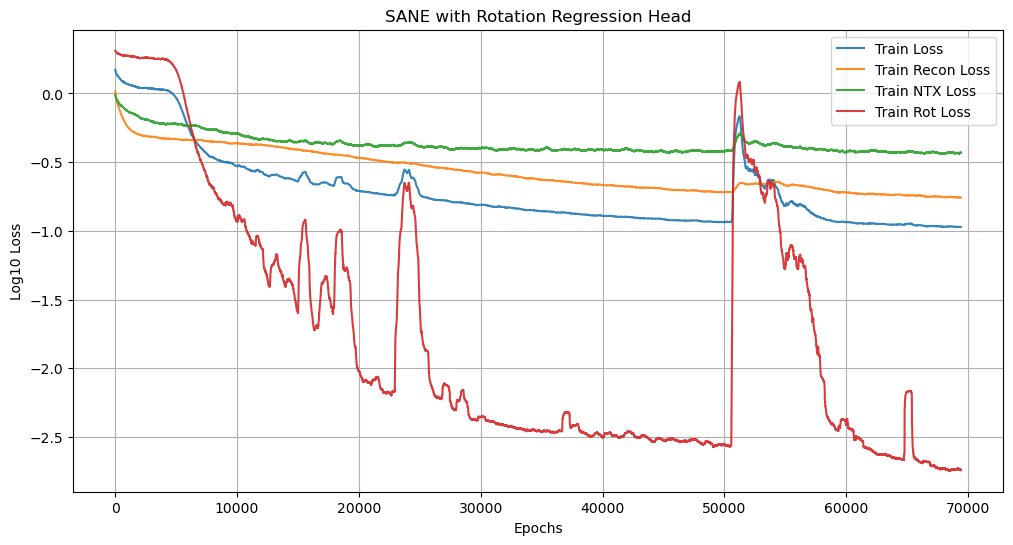

In [151]:
fig,ax = plt.subplots(figsize = (12,6))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--']  # solid for train, dashed for test


for data,label,color in zip(train_data, metric.train_labels,colors):
    data = uniform_smooth(data, window_size=600)
    data = np.log10(data)
    
    ax.plot(data, '-', c=color, label = "Train " +label , alpha=0.9, linewidth = 1.5)
    
window_size = 6
for data,label,color in zip(test_data, metric.train_labels,colors):
    data = uniform_smooth(data, window_size = window_size)
    data = np.log10(data)
    
    ax.plot(metric.test_data_ix[window_size//2:-(window_size//2-1)],data,'--', label = "Test " + label )
    
plt.xlabel("Epochs")
plt.ylabel("Log10 Loss")
plt.title("SANE with Rotation Regression Head")
plt.grid()
plt.legend()
plt.savefig("rot.png")

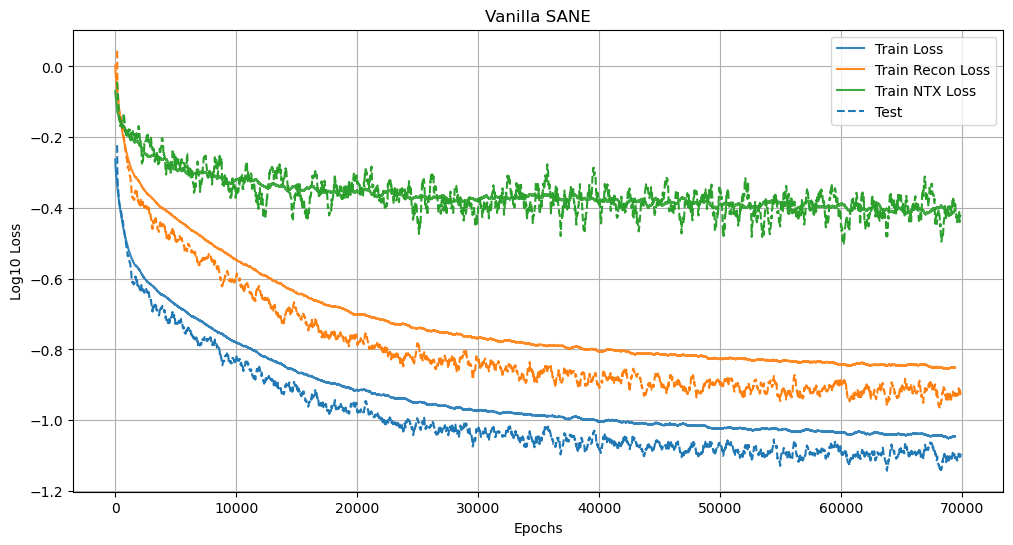

In [181]:
fig,ax = plt.subplots(figsize = (12,6))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--']  # solid for train, dashed for test


for data,label,color in zip(train_data, metric.train_labels,colors):
    data = uniform_smooth(data, window_size=600)
    data = np.log10(data)
    
    ax.plot(data, '-', c=color, label = "Train " +label , alpha=0.9, linewidth = 1.5)
    
window_size = 12
for data,label,color in zip(test_data, metric.train_labels,colors):
    data = uniform_smooth(data, window_size = window_size)
    data = np.log10(data)
    if label == "Loss":
        ax.plot(metric.test_data_ix[window_size//2:-(window_size//2-1)],data,'--', label = "Test" )
    else:
        ax.plot(metric.test_data_ix[window_size//2:-(window_size//2-1)],data,'--')
plt.xlabel("Epochs")
plt.ylabel("Log10 Loss")
plt.title("Vanilla SANE")
plt.grid()
plt.legend()
plt.savefig("vanilla.png")

In [18]:
x = torch.rand((100,15,25))
x[:,0,4:] = 0
x[:,0]

tensor([[0.1986, 0.7266, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
        [0.3341, 0.3053, 0.6683,  ..., 0.0000, 0.0000, 0.0000],
        [0.9557, 0.2409, 0.9680,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8691, 0.4089, 0.2055,  ..., 0.0000, 0.0000, 0.0000],
        [0.1463, 0.6136, 0.0574,  ..., 0.0000, 0.0000, 0.0000],
        [0.1434, 0.0662, 0.2859,  ..., 0.0000, 0.0000, 0.0000]])